# **Setup**

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models,optimizers,layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [3]:
drive_path = '/content/drive'
from google.colab import drive
drive.mount(drive_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Paths to the directories for resolution
BASE_DIR = f'{drive_path}/MyDrive/Colab_Notebooks/Projet IA M2/resolution'
HR_TRAIN_PATH = os.path.join(BASE_DIR, "DIV2K_train_HR")
LR_TRAIN_PATH = os.path.join(BASE_DIR, "DIV2K_train_LR_bicubic_X4/X4")
HR_VALID_PATH = os.path.join(BASE_DIR, "DIV2K_valid_HR")
LR_VALID_PATH = os.path.join(BASE_DIR, "DIV2K_valid_LR_bicubic_X4/X4")

# Paths to the directories for colorisation
ROOT_DIR = f'{drive_path}/MyDrive/Colab_Notebooks/Projet IA M2/colorisation'
BLACK_TRAIN_PATH = os.path.join(ROOT_DIR,"train_black")
COLOR_TRAIN_PATH = os.path.join(ROOT_DIR,"train_color")
BLACK_VALID_PATH = os.path.join(ROOT_DIR,"test_black")
COLOR_VALID_PATH = os.path.join(ROOT_DIR,"test_color")

# Model

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# Fonction pour construire un modèle ViT personnalisé
def create_vit_model(input_shape):
    # Entrée
    inputs = layers.Input(shape=input_shape)

    # Patch Embedding
    patch_size = 16
    num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)
    projection_dim = 64

    patches = layers.Conv2D(projection_dim, patch_size, strides=patch_size, padding="valid")(inputs)
    patches = layers.Reshape((num_patches, projection_dim))(patches)

    # Ajout d'un embedding positionnel
    position_embedding = tf.Variable(tf.random.normal([1, num_patches, projection_dim]), trainable=True)
    embedded_patches = patches + position_embedding

    # Transformer Encoder
    num_heads = 4
    num_transformer_layers = 4

    x = embedded_patches
    for _ in range(num_transformer_layers):
        # Multi-Head Self Attention
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim)(x, x)
        x = layers.Add()([x, attention_output])  # Résiduel
        x = layers.LayerNormalization()(x)

        # Feed Forward Network
        ffn = layers.Dense(128, activation="relu")(x)
        ffn = layers.Dense(projection_dim)(ffn)
        x = layers.Add()([x, ffn])  # Résiduel
        x = layers.LayerNormalization()(x)

    # Décodage corrigé
    x = layers.Reshape((input_shape[0] // patch_size, input_shape[1] // patch_size, projection_dim))(x)

    # Augmentation progressive des dimensions avec des convolutions transposées
    x = layers.Conv2DTranspose(128, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(3, 3, strides=2, padding="same", activation="sigmoid")(x)  # Dernière couche de sortie
    outputs = x

    # Création du modèle
    model = Model(inputs, outputs)
    model.compile(optimizer="adam", loss="mse", metrics=["accuracy"])
    return model

# Initialisation du modèle
input_shape = (160, 160, 3)  # Par exemple : entrée en basse résolution
vit_model = create_vit_model(input_shape)
vit_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 160, 160, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 10, 10, 64)     │         49,216 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 100, 64)        │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 100, 64)        │              0 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 100, 64)        │         66,368 │ add[0][0], add[0][0]   │
│ (MultiHeadAttention)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 100, 64)        │              0 │ add[0][0],             │
│                           │                        │                │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 100, 64)        │            128 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 100, 128)       │          8,320 │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 100, 64)        │          8,256 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 100, 64)        │              0 │ layer_normalization[0… │
│                           │                        │                │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 100, 64)        │            128 │ add_2[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 100, 64)        │         66,368 │ layer_normalization_1… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_3 (Add)               │ (None, 100, 64)        │              0 │ layer_normalization_1… │
│                           │                        │                │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 100, 64)        │            128 │ add_3[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 100, 128)       │          8,320 │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)      

 Total params: 548,995 (2.09 MB)

 Trainable params: 548,995 (2.09 MB)

 Non-trainable params: 0 (0.00 B)

# Colorization

## Preprocessing

In [6]:
# Load image paths
def load_image_paths(color_path, black_path):
    color_images = sorted([os.path.join(color_path, img) for img in os.listdir(color_path)])
    black_images = sorted([os.path.join(black_path, img) for img in os.listdir(black_path)])
    return color_images, black_images

# Preprocess images
def preprocess_images(color_path, black_path, target_color_size=(160, 160), target_black_size=(160, 160)):
    color_images = []
    black_images = []
    for color_path, black_path in zip(color_path, black_path):
        color_image = load_img(color_path, target_size=target_color_size)
        black_image = load_img(black_path, target_size=target_black_size)
        color_images.append(img_to_array(color_image) / 255.0)
        black_images.append(img_to_array(black_image) / 255.0)
        if len(color_images) >= 1000:
            break
    return np.array(black_images), np.array(color_images)

In [7]:
# Load and preprocess the data
color_train_paths, black_train_paths = load_image_paths(COLOR_TRAIN_PATH, BLACK_TRAIN_PATH)
color_valid_paths, black_valid_paths = load_image_paths(COLOR_VALID_PATH, BLACK_VALID_PATH)

x_train, y_train = preprocess_images(color_train_paths, black_train_paths)
x_val, y_val = preprocess_images(color_valid_paths, black_valid_paths)

In [11]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(1000, 160, 160, 3)
(1000, 160, 160, 3)
(739, 160, 160, 3)
(739, 160, 160, 3)


## Training

In [8]:
EPOCHS = 100
BATCH_SIZE = 16

# Création de datasets TensorFlow pour l'entraînement
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(BATCH_SIZE).shuffle(1000)
valid_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(BATCH_SIZE)

# Entraînement
history = vit_model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=EPOCHS
)

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 37s 227ms/step - accuracy: 0.3681 - loss: 0.0656 - val_accuracy: 0.4805 - val_loss: 0.0370
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.4725 - loss: 0.0320 - val_accuracy: 0.5013 - val_loss: 0.0241
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.4728 - loss: 0.0225 - val_accuracy: 0.5043 - val_loss: 0.0213
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.5118 - loss: 0.0210 - val_accuracy: 0.4927 - val_loss: 0.0207
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.4762 - loss: 0.0205 - val_accuracy: 0.5229 - val_loss: 0.0217
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5073 - loss: 0.0195 - val_accuracy: 0.4834 - val_loss: 0.0193
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.4919 - loss: 0.0189 - val_accuracy: 0.5033 - val_loss: 0.0185
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.4735 - loss: 0.0181 - val_accuracy:

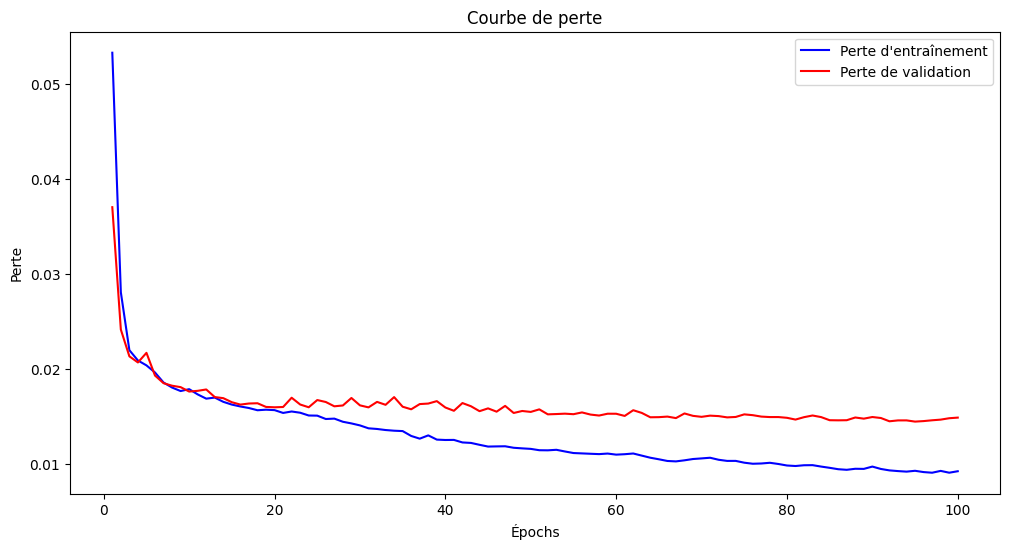

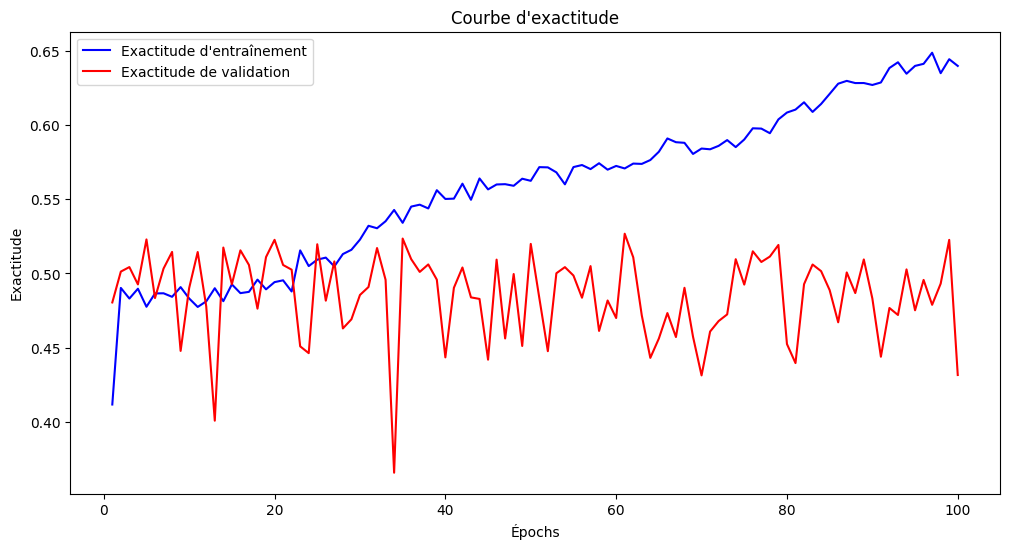

In [9]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Récupération des données d'entraînement et de validation
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Vérifier si une métrique est disponible
    if 'accuracy' in history.history:
        accuracy = history.history['accuracy']
        val_accuracy = history.history['val_accuracy']
    else:
        accuracy = val_accuracy = None

    epochs = range(1, len(loss) + 1)

    # Tracer la courbe de perte
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, loss, 'b', label='Perte d\'entraînement')
    plt.plot(epochs, val_loss, 'r', label='Perte de validation')
    plt.title('Courbe de perte')
    plt.xlabel('Épochs')
    plt.ylabel('Perte')
    plt.legend()
    plt.show()

    # Tracer la courbe de métrique si disponible
    if accuracy is not None:
        plt.figure(figsize=(12, 6))
        plt.plot(epochs, accuracy, 'b', label='Exactitude d\'entraînement')
        plt.plot(epochs, val_accuracy, 'r', label='Exactitude de validation')
        plt.title('Courbe d\'exactitude')
        plt.xlabel('Épochs')
        plt.ylabel('Exactitude')
        plt.legend()
        plt.show()

# Appeler la fonction avec les résultats d'entraînement
plot_training_history(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


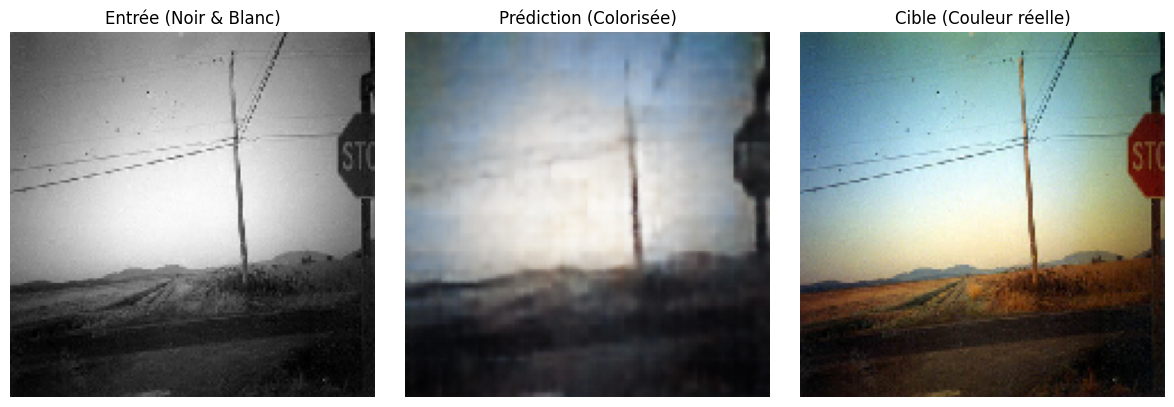

In [10]:
import matplotlib.pyplot as plt

def display_results(black_image, predicted_image, real_image):
    """
    Affiche une comparaison entre l'image noir et blanc (entrée),
    l'image colorisée par le modèle (prédite), et l'image réelle (cible).
    """
    plt.figure(figsize=(12, 4))

    # Image noir et blanc (entrée)
    plt.subplot(1, 3, 1)
    plt.imshow(black_image.squeeze(), cmap='gray')  # Suppression de la 3e dimension si NB
    plt.title("Entrée (Noir & Blanc)")
    plt.axis('off')

    # Image prédite (colorisée par le modèle)
    plt.subplot(1, 3, 2)
    plt.imshow(predicted_image)
    plt.title("Prédiction (Colorisée)")
    plt.axis('off')

    # Image réelle (cible)
    plt.subplot(1, 3, 3)
    plt.imshow(real_image)
    plt.title("Cible (Couleur réelle)")
    plt.axis('off')

    # Afficher le résultat
    plt.tight_layout()
    plt.show()

# Exemple d'utilisation
# Sélectionner une image dans x_val
index = 0  # Choisir une image spécifique
black_input = x_val[index]  # Image noir et blanc d'entrée (prétraitée)
real_target = y_val[index]  # Image couleur réelle (cible)

# Générer une prédiction avec le modèle
predicted_output = vit_model.predict(np.expand_dims(black_input, axis=0))[0]

# Recaler les valeurs de la prédiction dans [0, 1]
predicted_output = np.clip(predicted_output, 0, 1)

# Afficher les résultats
display_results(black_input, predicted_output, real_target)

# Resolution part

## Preprocessing

In [7]:
# Load image paths
def load_image_paths(hr_path, lr_path):
    hr_images = sorted([os.path.join(hr_path, img) for img in os.listdir(hr_path)])
    lr_images = sorted([os.path.join(lr_path, img) for img in os.listdir(lr_path)])
    return hr_images, lr_images

# Preprocess images
def preprocess_images(hr_paths, lr_paths, target_hr_size=(160, 160), target_lr_size=(160, 160)):
    hr_images = []
    lr_images = []
    for hr_path, lr_path in zip(hr_paths, lr_paths):
        hr_image = load_img(hr_path, target_size=target_hr_size)
        lr_image = load_img(lr_path, target_size=target_lr_size)
        hr_images.append(img_to_array(hr_image) / 255.0)
        lr_images.append(img_to_array(lr_image) / 255.0)
    return np.array(lr_images), np.array(hr_images)

In [8]:
# Load and preprocess the data
hr_train_paths, lr_train_paths = load_image_paths(HR_TRAIN_PATH, LR_TRAIN_PATH)
hr_valid_paths, lr_valid_paths = load_image_paths(HR_VALID_PATH, LR_VALID_PATH)

x_train, y_train = preprocess_images(hr_train_paths, lr_train_paths)
x_val, y_val = preprocess_images(hr_valid_paths, lr_valid_paths)

In [9]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(800, 160, 160, 3)
(800, 160, 160, 3)
(100, 160, 160, 3)
(100, 160, 160, 3)


## Training

In [10]:
EPOCHS = 500
BATCH_SIZE = 16

# Création de datasets TensorFlow pour l'entraînement
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(BATCH_SIZE).shuffle(1000)
valid_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(BATCH_SIZE)

# Entraînement
history = vit_model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=EPOCHS
)

Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 31s 93ms/step - accuracy: 0.3743 - loss: 0.0702 - val_accuracy: 0.3841 - val_loss: 0.0499
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.4142 - loss: 0.0477 - val_accuracy: 0.3852 - val_loss: 0.0410
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4018 - loss: 0.0381 - val_accuracy: 0.4349 - val_loss: 0.0310
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.4699 - loss: 0.0307 - val_accuracy: 0.4789 - val_loss: 0.0285
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5581 - loss: 0.0273 - val_accuracy: 0.5839 - val_loss: 0.0247
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6269 - loss: 0.0240 - val_accuracy: 0.6298 - val_loss: 0.0239
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6621 - loss: 0.0233 - val_accuracy: 0.6202 - val_loss: 0.0234
Epoch 8/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6670 - loss: 0.0223 - val_accuracy: 0

## Results

### Plots

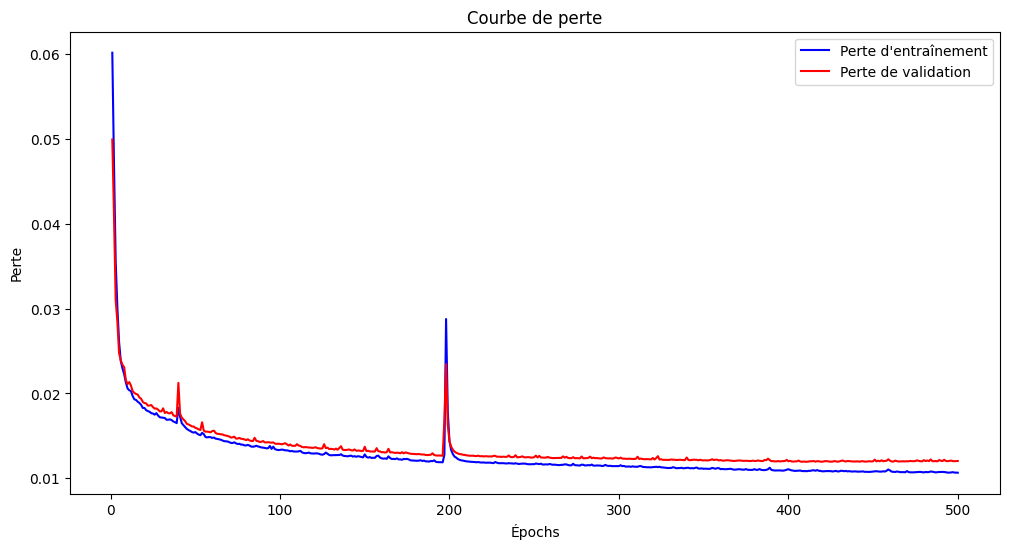

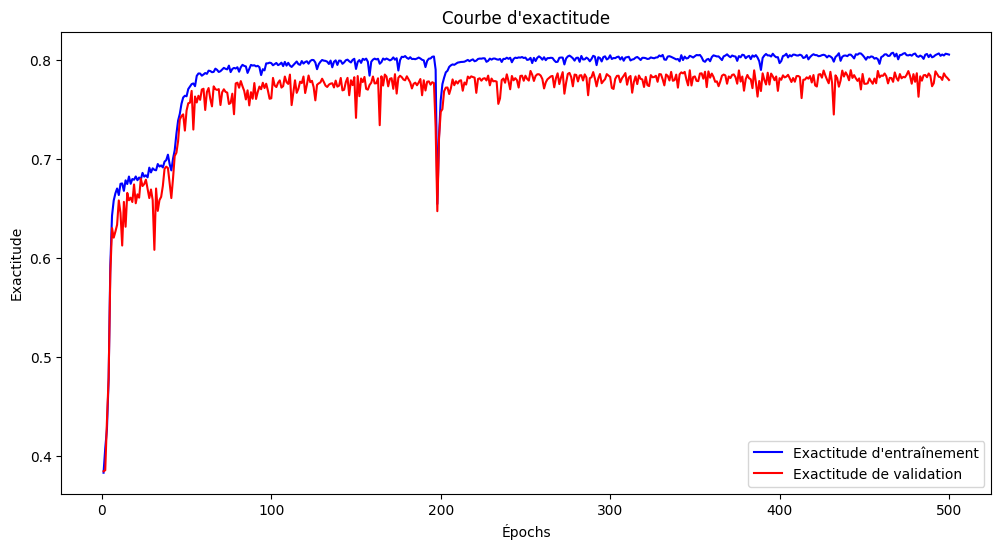

In [11]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Récupération des données d'entraînement et de validation
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Vérifier si une métrique est disponible
    if 'accuracy' in history.history:
        accuracy = history.history['accuracy']
        val_accuracy = history.history['val_accuracy']
    else:
        accuracy = val_accuracy = None

    epochs = range(1, len(loss) + 1)

    # Tracer la courbe de perte
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, loss, 'b', label='Perte d\'entraînement')
    plt.plot(epochs, val_loss, 'r', label='Perte de validation')
    plt.title('Courbe de perte')
    plt.xlabel('Épochs')
    plt.ylabel('Perte')
    plt.legend()
    plt.show()

    # Tracer la courbe de métrique si disponible
    if accuracy is not None:
        plt.figure(figsize=(12, 6))
        plt.plot(epochs, accuracy, 'b', label='Exactitude d\'entraînement')
        plt.plot(epochs, val_accuracy, 'r', label='Exactitude de validation')
        plt.title('Courbe d\'exactitude')
        plt.xlabel('Épochs')
        plt.ylabel('Exactitude')
        plt.legend()
        plt.show()

# Appeler la fonction avec les résultats d'entraînement
plot_training_history(history)

### Visualization

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


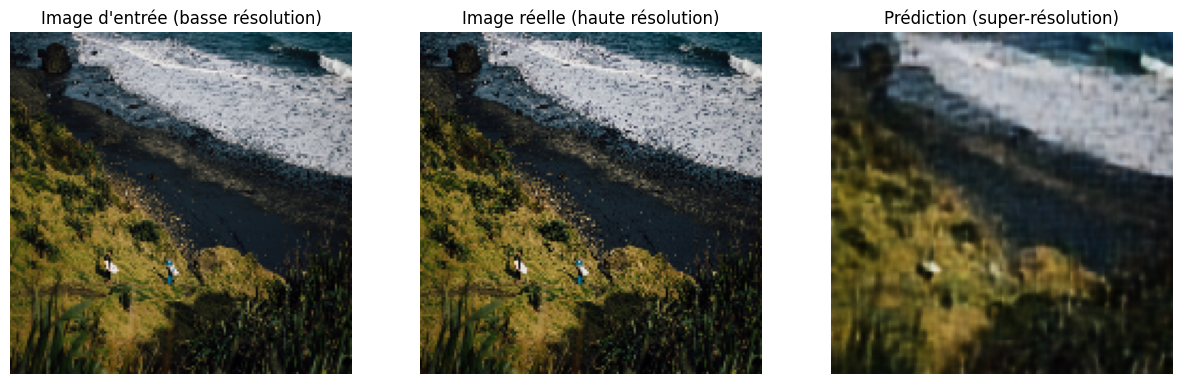

In [12]:
def display_results(low_res_image, high_res_image, predicted_image):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(low_res_image)
    axes[0].set_title("Image d'entrée (basse résolution)")
    axes[0].axis("off")

    axes[1].imshow(high_res_image)
    axes[1].set_title("Image réelle (haute résolution)")
    axes[1].axis("off")

    axes[2].imshow(predicted_image)
    axes[2].set_title("Prédiction (super-résolution)")
    axes[2].axis("off")
    plt.show()

# Prédiction sur une image de test
sample_idx = 10
low_res_input = x_val[sample_idx][np.newaxis, ...]  # Ajouter une dimension batch
high_res_ground_truth = y_val[sample_idx]
predicted_output = vit_model.predict(low_res_input)[0]

# Affichage des résultats
display_results(low_res_input[0], high_res_ground_truth, predicted_output)